<h1 align=center>New York Times</h1>

---

## Overview of the Notebook

This notebook focuses on developing a **topic classification system** for **The New York Times Articles** using **LDA (Latent Dirichlet Allocation)** and **NMF (Non-Negative Matrix Factorization)** models. The dataset, a curated subset of 500k articles, provides a rich foundation for text analysis with features such as `Title`, `Abstract`, and `Lead_Paragraph`.

### Use Cases
The topic classification system aims to address multiple real-world applications:
1. **Personalized Content Recommendations**: Deliver tailored article suggestions to enhance reader engagement.
2. **Content Categorization and Metadata Enhancement**: Automate the tagging and classification of articles for improved organization and discoverability.
3. **Audience Segmentation**: Group readers based on their interests for targeted marketing and content delivery.
4. **Trend Analysis and Insights**: Uncover trends in topics and reader interests to inform editorial strategies.
5. **Advertiser Alignment**: Match articles to relevant advertisers to optimize revenue through better targeting.

### Preprocessing Steps
To prepare the data for modeling, the following preprocessing steps were performed:
- **Data Cleaning**: Handled null values and removed irrelevant characters to ensure data quality.
- **Tokenization and Lemmatization**: Converted text into tokens and reduced words to their base forms for consistency.
- **Stopword Removal**: Eliminated common words that do not contribute to meaningful analysis.
- **Feature Extraction**: Applied **Term Frequency-Inverse Document Frequency (TF-IDF)** to represent the text as numerical features, emphasizing unique and significant terms.

This preprocessing pipeline ensures that the models are trained on clean, representative data, laying the groundwork for robust and insightful topic classification.

In [1]:
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis  # plotting
import pyLDAvis.sklearn  # plotting

from sklearn import manifold
from wordcloud import STOPWORDS
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



def lemmatize(wrd):
    import nltk

    out = nltk.corpus.wordnet.morphy(wrd)
    return (wrd if out is None else out)

def clean_text(txt):
    # identify language of tweet
    
    # split the string on whitespace
    out = txt.split(' ')
    
    # identify screen names
    # replace with SCREENNAME
    out = ['SCREENNAME' if i.startswith('@') else i for i in out]
    
    # identify urls
    # replace with URL
    out = [
        'URL' if bool(re.search('http[s]?://', i)) 
        else i for i in out
    ]
    
    # remove all punctuation
    out = [re.sub('[^\\w\\s]|\n', '', i) for i in out]
    
    # make all non-keywords lowercase
    keys = ['SCREENNAME', 'URL']
    out = [i.lower() if i not in keys else i for i in out]
    
    # remove keywords
    out = [i for i in out if i not in keys]
    
    # remove stopwords
    list_stop_words = STOPWORDS
    list_stop_words = [re.sub('[^\\w\\s]', '', i) for i in list_stop_words]
    
    out = [i for i in out if i not in list_stop_words]
    
    # lemmatizing
    out = [lemmatize(i) for i in out]
    
    # keep words 4 or more characters long
    out = [i for i in out if len(i) >= 5]
    
    return ' '.join(out)
    

# define function to reformat output matrices into easily readable tables
def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, np.newaxis]
    # topic to document matrix
    H = mod.transform(vec)
    
    W_dict = {}
    H_dict = {}
    
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)
        
        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in W_indices
        ]
        W_dict[topic] = W_names_values
        
        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j]) 
            for j in H_indices
        ]
        H_dict[topic] = H_names_values
        
    W_df = pd.DataFrame(
        W_dict, 
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pd.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )
        
    return (W_df, H_df)

# define functiont to fit and plot t-SNE model

def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = np.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]
    
    # fit tsne model
    # x-d -> 2-d, x = number of topics
    tsne = manifold.TSNE(
        n_components=2, 
        verbose=0, 
        random_state=0, 
        angle=0.5, 
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)
    
    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())
    
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = np.unique(
        np.array(most_prob_topic), 
        return_counts=True
    )

    print("COUNTS:\n{}\n".format(np.asarray((unique, counts)).T))
    
    # make plot
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        plt.scatter(
            x=tsne_fit[indices, 0], 
            y=tsne_fit[indices, 1], 
            s=0.5, 
            c=color_list[i], 
            label='Topic' + str(i),
            alpha=0.25
        )

    plt.xlabel('x-tsne')
    plt.ylabel('y-tsne')
    plt.legend(markerscale=10)

<h2>Data</h2>

---

In [2]:
# data.to_csv('data/wikipedia.csv')
data = pd.read_csv('./data/nyt-small500k_v3.csv', index_col='index', usecols=['index', 'title','abstract', 'lead_paragraph'])
data.head()

,abstract,lead_paragraph,title
index,,,
0,The choice of Yi Gang almost guarantees stabil...,China plans to name a new leader for its centr...,China to Name New Central Bank Chief as It See...
1,Funeral for Cuban salsa singer Celia Cruz is h...,"She knew that a lady named Celia was dead, but...",A 5-Year-Old Sees the Horses and Says Farewell...
2,"In his annual prognostication, Punxsutawney Ph...",NaN,Tired of winter yet? The groundhog isn’t.
3,With Trump using immigration simply for politi...,"LIMA, Peru — Kamala Harris, the Democratic sen...",We Need a High Wall With a Big Gate
4,"Rather than create an “Uber for Assault,” the ...","At first, it seemed like a brilliant marketing...",Chinese Company Says It Never Planned a ‘Thugs...


In [3]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [4]:
data = data.sample(frac=0.05, random_state=42)

In [5]:
data.shape

(24294, 3)

In [6]:
data['document'] = data['abstract'] + data['lead_paragraph'] + data['title']
data.head()

,abstract,lead_paragraph,title,document
index,,,,
323382,"The district attorney, Charles J. Hynes, is se...","The Brooklyn district attorney, Charles J. Hyn...",Brooklyn Prosecutor to Target Intimidation in ...,"The district attorney, Charles J. Hynes, is se..."
296851,Op-Ed article by former New York City Parks De...,HERE'S a not very comforting thought: As summe...,Yellow Jackets in Season,Op-Ed article by former New York City Parks De...
388374,Bush administration is considering extending h...,The Bush administration is considering extendi...,Heightened Terrorism Alert May Last Beyond Hol...,Bush administration is considering extending h...
368506,The lifting of restrictions is an early test o...,"BERLIN — Slowly, tentatively, a handful of Eur...","Some European Nations Ease Pandemic Rules, but...",The lifting of restrictions is an early test o...
410766,"Monday: It’s too early to say for sure, but so...",Good morning.,Why Are California and New York Different in t...,"Monday: It’s too early to say for sure, but so..."


In [7]:
%%time
data['processed'] = data['document'].apply(clean_text)

Wall time: 1min 20s


In [8]:
data.reset_index(inplace=True)

In [9]:
data.head()

,index,abstract,lead_paragraph,title,document,processed
0,323382,"The district attorney, Charles J. Hynes, is se...","The Brooklyn district attorney, Charles J. Hyn...",Brooklyn Prosecutor to Target Intimidation in ...,"The district attorney, Charles J. Hynes, is se...",district attorney charles hynes setting force ...
1,296851,Op-Ed article by former New York City Parks De...,HERE'S a not very comforting thought: As summe...,Yellow Jackets in Season,Op-Ed article by former New York City Parks De...,article former parks department gardener const...
2,388374,Bush administration is considering extending h...,The Bush administration is considering extendi...,Heightened Terrorism Alert May Last Beyond Hol...,Bush administration is considering extending h...,administration consider extend heighten terror...
3,368506,The lifting of restrictions is an early test o...,"BERLIN — Slowly, tentatively, a handful of Eur...","Some European Nations Ease Pandemic Rules, but...",The lifting of restrictions is an early test o...,restriction early whether democracy restart ec...
4,410766,"Monday: It’s too early to say for sure, but so...",Good morning.,Why Are California and New York Different in t...,"Monday: It’s too early to say for sure, but so...",monday early expert early action california le...


<h1>Modeling</h1>


In [10]:
number_words = 10
number_docs = 10
number_features = 10000

In [11]:
vectorizer1 = TfidfVectorizer(
        analyzer="word",
        max_df=0.75, 
        min_df=50, 
        max_features=number_features, 
        smooth_idf=False
)
clean_vec1 = vectorizer1.fit_transform(data['processed'])
print(clean_vec1[0])

  (0, 2118)	0.13635992220146909
  (0, 1144)	0.13622378629037488
  (0, 249)	0.16340775624336426
  (0, 2341)	0.14526679247025848
  (0, 525)	0.16340775624336426
  (0, 1115)	0.14970849171090655
  (0, 1649)	0.2656507461602065
  (0, 1491)	0.13989774205076086
  (0, 276)	0.22553016920517419
  (0, 533)	0.12997131580834287
  (0, 1770)	0.09256073528340739
  (0, 2267)	0.13365898487251776
  (0, 10)	0.4074605645701332
  (0, 1918)	0.279477675186426
  (0, 358)	0.2011597447364435
  (0, 827)	0.09392064862249282
  (0, 1609)	0.13247723353336555
  (0, 435)	0.23768987464656466
  (0, 416)	0.15371927335003394
  (0, 874)	0.10615669252583369
  (0, 1911)	0.278848625285562
  (0, 345)	0.26270744142665514
  (0, 176)	0.2678057326272516
  (0, 656)	0.24646307075102072


In [12]:
feature_names_vec1 = vectorizer1.get_feature_names()

c:\Users\suraj\anaconda3\envs\unsup\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# define function to calculate perplexity for LDA model trained on ntopics

def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [], 
        "Perplexity Score": []
    }
    
    for t in ntopics:
        lda = LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0
        )
        lda.fit(data)
        
        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))
        
    output_df = pd.DataFrame(output_dict)
    
    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]
        
    return (output_df, output_num_topics)

In [14]:
# find perplexity scores for several different numbers of topics
# takes several minutes
df_perplexity, optimal_num_topics = perplexity_by_ntopic(
    clean_vec1, 
    ntopics=range(1, 11)
)

In [16]:
print(df_perplexity)

   Number Of Topics  Perplexity Score
0                 1       1889.769723
1                 2       2179.230758
2                 3       2526.355338
3                 4       3217.610226
4                 5       3579.175885
5                 6       4015.580067
6                 7       4678.602225
7                 8       4820.762880
8                 9       5535.309412
9                10       5732.236657


<AxesSubplot:>

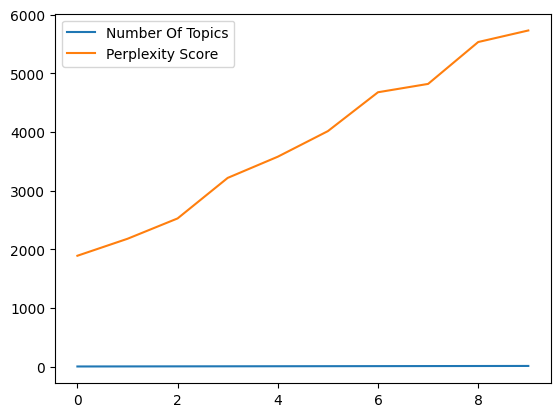

In [15]:
df_perplexity.plot.line()


<h2>LDA</h2>

---

<h4>LDA_1</h4>

In [ ]:
lda = LatentDirichletAllocation(
    n_components=4,
    learning_method='online',
    random_state=0
)
lda.fit(clean_vec1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
lda_transform = lda.transform(clean_vec1)
print(lda_transform.shape)

(24294, 4)


LENGTH:
3851

COUNTS:
[[   0   49]
 [   1 2740]
 [   2  270]
 [   3  792]]



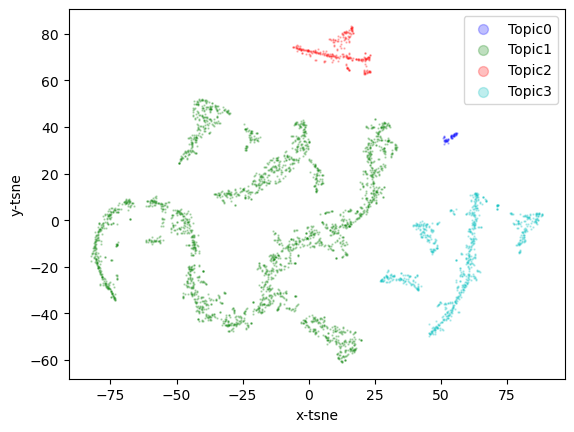

In [ ]:
plot_tsne(lda_transform, threshold=0.75)

In [ ]:
# run function
W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [ ]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3
Word0,"(0.0129, museum)","(0.0049, article)","(0.0163, company)","(0.0088, state)"
Word1,"(0.0094, design)","(0.0047, years)","(0.0138, million)","(0.0077, president)"
Word2,"(0.0089, space)","(0.0045, first)","(0.0111, billion)","(0.0055, government)"
Word3,"(0.0083, collection)","(0.0044, photo)","(0.0107, percent)","(0.0053, unite)"
Word4,"(0.0076, guide)","(0.0041, family)","(0.0092, market)","(0.0047, republican)"
Word5,"(0.0074, afghanistan)","(0.004, death)","(0.0078, price)","(0.0047, official)"
Word6,"(0.0073, american)","(0.004, night)","(0.0065, yankee)","(0.0046, trump)"
Word7,"(0.0073, water)","(0.004, times)","(0.0064, editorto)","(0.0046, people)"
Word8,"(0.0072, dance)","(0.0038, woman)","(0.0063, executive)","(0.0044, health)"
Word9,"(0.0069, looking)","(0.0036, school)","(0.0063, business)","(0.0041, federal)"


In [ ]:
H_df.head(2)

,Topic0,Topic1,Topic2,Topic3
Doc0,"(0.834, The Department of Defense has identifi...","(0.9015, TOWNSEND--Jo-Ann. The Institute for P...","(0.8726, World Business Briefing: JaFujitsu lo...","(0.8835, Removing information from manuscripts..."
Doc1,"(0.8323, The Department of Defense has identif...","(0.9012, GOLDMAN-Byron. On March 28, 2000. Lov...","(0.8724, Wolverine World Wide says that analys...","(0.8642, The House voted to approve sweeping m..."


<h4>LDA_2</h4>

In [ ]:
lda = LatentDirichletAllocation(
    n_components=5,
    learning_method='online',
    random_state=111
)
lda.fit(clean_vec1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=111, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
print(lda_transform.shape)

(24294, 5)


LENGTH:
2605

COUNTS:
[[   0  509]
 [   1  165]
 [   2 1660]
 [   3  251]
 [   4   20]]



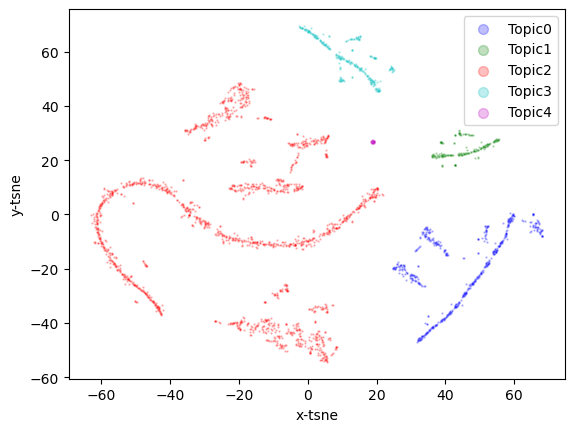

In [ ]:
plot_tsne(lda_transform, threshold=0.75)

In [ ]:
# run function
W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [ ]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4
Word0,"(0.0092, death)","(0.0084, review)","(0.0064, state)","(0.0109, president)","(0.0124, fashion)"
Word1,"(0.0082, notice)","(0.0076, music)","(0.0054, million)","(0.0098, republican)","(0.011, yankee)"
Word2,"(0.0074, beloved)","(0.0075, photo)","(0.0052, company)","(0.0089, article)","(0.011, season)"
Word3,"(0.0073, married)","(0.0063, museum)","(0.0045, unite)","(0.008, trump)","(0.0108, editorto)"
Word4,"(0.0073, daughter)","(0.0062, street)","(0.0044, american)","(0.0078, election)","(0.0103, player)"
Word5,"(0.0072, church)","(0.0058, theater)","(0.004, people)","(0.0072, reader)","(0.0099, league)"
Word6,"(0.0068, family)","(0.0058, movie)","(0.004, report)","(0.0072, editor)","(0.0094, college)"
Word7,"(0.0065, numbers)","(0.0056, restaurant)","(0.0039, government)","(0.0071, times)","(0.0091, letter)"
Word8,"(0.0065, mother)","(0.0054, night)","(0.0039, percent)","(0.0069, house)","(0.0087, spring)"
Word9,"(0.0065, memorial)","(0.0052, manhattan)","(0.0038, official)","(0.0065, campaign)","(0.0083, novel)"


In [ ]:
H_df.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,"(0.8844, SCHWARTZ--Gabriel B. Age 78, after a ...","(0.8484, Ruth La Ferla article contrasts priva...","(0.877, INTERNATIONAL A3-13 Fighting Eru...","(0.8674, David Chen On Politics column on stro...","(0.8251, Minnesota Twins pitcher Kenny Rogers ..."
Doc1,"(0.8744, KAPLAN-George I. On Friday, June 30, ...","(0.8412, Angelika and Benedikt Tschen restore ...","(0.8748, INTERNATIONAL A3-32 Sharon Expr...","(0.8543, President Obama confirmed Monday morn...","(0.8182, Murray Chass On Baseball column discu..."


<h4>LDA_3</h4>

In [ ]:
lda = LatentDirichletAllocation(
    n_components=6,
    learning_method='online',
    random_state=0
)
lda.fit(clean_vec1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
print(lda_transform.shape)

(24294, 6)


LENGTH:
1967

COUNTS:
[[  0 127]
 [  1 295]
 [  3 133]
 [  4 561]
 [  5 851]]



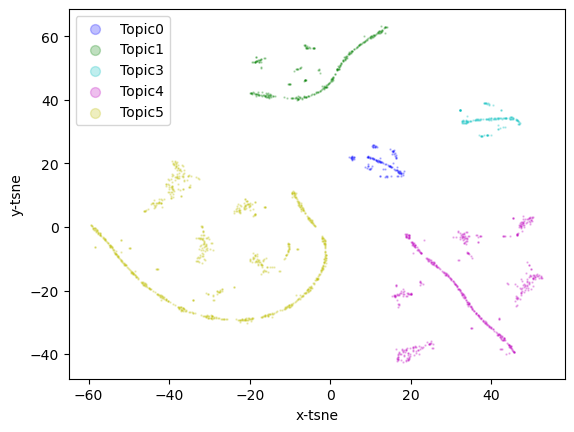

In [ ]:
plot_tsne(lda_transform, threshold=0.75)

In [ ]:
# run function
W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [ ]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Word0,"(0.0204, company)","(0.0062, review)","(0.0249, article)","(0.0081, season)","(0.0105, state)","(0.0093, school)"
Word1,"(0.0165, million)","(0.0062, photo)","(0.0207, editorto)","(0.0075, first)","(0.01, president)","(0.008, death)"
Word2,"(0.0147, percent)","(0.0061, music)","(0.0165, energy)","(0.0062, world)","(0.0061, unite)","(0.0075, family)"
Word3,"(0.013, billion)","(0.0046, reader)","(0.0152, prime)","(0.0059, player)","(0.0061, government)","(0.0074, police)"
Word4,"(0.0115, market)","(0.0044, museum)","(0.0145, briefing)","(0.0058, fashion)","(0.006, republican)","(0.0065, child)"
Word5,"(0.0096, executive)","(0.0043, video)","(0.0141, letter)","(0.0054, giant)","(0.006, official)","(0.0065, mother)"
Word6,"(0.009, price)","(0.0042, times)","(0.0132, coronavirus)","(0.005, league)","(0.0056, trump)","(0.0059, notice)"
Word7,"(0.0087, business)","(0.0039, story)","(0.0127, editor)","(0.0048, sport)","(0.0054, court)","(0.0056, university)"
Word8,"(0.0084, financial)","(0.0038, night)","(0.012, israel)","(0.0045, coach)","(0.0051, american)","(0.0055, beloved)"
Word9,"(0.0077, chief)","(0.0038, years)","(0.0116, french)","(0.0044, night)","(0.0048, election)","(0.0055, father)"


In [ ]:
H_df.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Doc0,"(0.8455, Evercore Partners reported its first ...","(0.8605, An animated ad on a wall at Eighth Av...","(0.7404, To the Editor:.To the Editor: Bottled...","(0.8408, A selective listing by Times critics ...","(0.8582, Disclosure of the proposal set off po...","(0.8838, MAGIDSON-Karen Zissu. In Westport, CT..."
Doc1,"(0.845, Stock of Concord Communications drops ...","(0.854, In the DOC NYC nonfiction film festiva...","(0.726, MIDDLE EAST.MIDDLE EASTWorld Briefings...","(0.8394, Jacoby Ellsbury stole 70 bases this s...","(0.8565, Editorial says Mayor Rudolph W Giulia...","(0.8806, SCHWARTZ--Gabriel B. Age 78, after a ..."


<h3>NMF</h3>

---

<h4>NMF_1</h4>

In [ ]:
nmf = NMF(
    n_components=4,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)
nmf_transform = nmf.transform(clean_vec1)

LENGTH:
24294

COUNTS:
[[    0 16804]
 [    1  2383]
 [    2  3039]
 [    3  2068]]



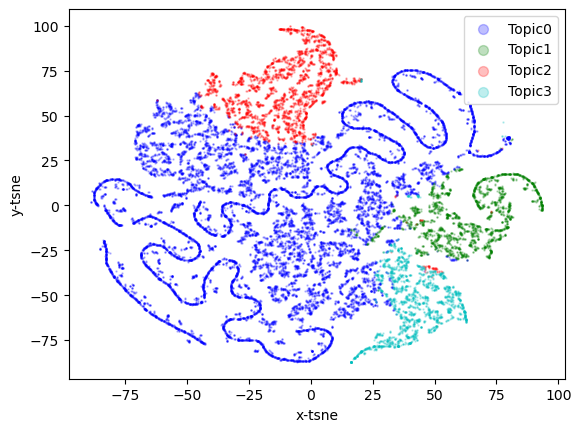

In [ ]:
plot_tsne(nmf_transform, threshold=0)

In [ ]:
# run function
W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [ ]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3
Word0,"(0.0064, company)","(0.0244, beloved)","(0.0494, president)","(0.1234, article)"
Word1,"(0.006, million)","(0.0227, death)","(0.0285, trump)","(0.0915, letter)"
Word2,"(0.0052, first)","(0.0208, family)","(0.0273, republican)","(0.0798, times)"
Word3,"(0.0051, years)","(0.0189, notice)","(0.0228, state)","(0.0493, editorto)"
Word4,"(0.0046, world)","(0.0164, husband)","(0.0169, election)","(0.0439, appear)"
Word5,"(0.0046, american)","(0.0161, mother)","(0.0167, obama)","(0.0259, editor)"
Word6,"(0.0043, state)","(0.0157, father)","(0.0165, house)","(0.0181, reader)"
Word7,"(0.004, photo)","(0.0149, friend)","(0.0143, party)","(0.0132, editorthe)"
Word8,"(0.0039, people)","(0.0141, services)","(0.0128, senator)","(0.0128, respond)"
Word9,"(0.0037, percent)","(0.0128, memorial)","(0.0126, campaign)","(0.0122, letters)"


In [ ]:
H_df.head(2)

,Topic0,Topic1,Topic2,Topic3
Doc0,"(0.0582, INTERNATIONAL A3-12 Olmert Offe...","(0.1002, LEIFER-Joel. Beloved husband of Doris...","(0.0836, Aired Wednesday night on NBC: Yesterd...","(0.1342, Roni Berenson letter on Oct 4 article..."
Doc1,"(0.0571, Internal Inquiry at Fannie Mae Finds...","(0.0977, DEREFINKO--Rodney S., on April 1, 200...","(0.0817, Mr. Lee lashed out after he said he w...","(0.1233, This word has appeared in 46 New York..."


<h4>NMF_2</h4>

In [ ]:
nmf = NMF(
    n_components=5,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)
nmf_transform = nmf.transform(clean_vec1)

LENGTH:
24294

COUNTS:
[[    0 16159]
 [    1  2408]
 [    2  2891]
 [    3  2050]
 [    4   786]]



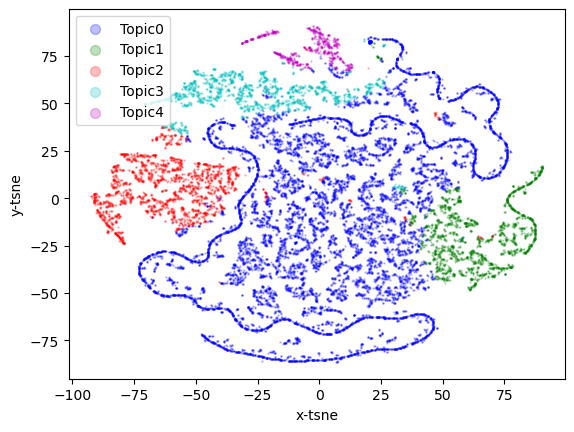

In [ ]:
plot_tsne(nmf_transform, threshold=0)

In [ ]:
# run function
W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [ ]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4
Word0,"(0.0068, company)","(0.0239, beloved)","(0.0514, president)","(0.0989, times)","(0.2654, editorto)"
Word1,"(0.0064, million)","(0.0223, death)","(0.0299, trump)","(0.0902, article)","(0.2281, letter)"
Word2,"(0.0052, first)","(0.0206, family)","(0.0284, republican)","(0.0449, appear)","(0.0548, letters)"
Word3,"(0.0052, years)","(0.0185, notice)","(0.0202, state)","(0.0256, review)","(0.0435, editor)"
Word4,"(0.0051, state)","(0.0161, husband)","(0.0177, house)","(0.0177, reader)","(0.039, editorthe)"
Word5,"(0.0048, american)","(0.0159, mother)","(0.0175, election)","(0.0157, photo)","(0.032, article)"
Word6,"(0.0046, world)","(0.0155, father)","(0.0175, obama)","(0.0115, editor)","(0.0309, editora)"
Word7,"(0.004, people)","(0.0147, friend)","(0.0149, party)","(0.0087, misstate)","(0.0235, articleto)"
Word8,"(0.004, percent)","(0.0138, services)","(0.0133, senator)","(0.0086, sport)","(0.0121, editorial)"
Word9,"(0.0037, report)","(0.0126, memorial)","(0.0131, campaign)","(0.0084, story)","(0.0116, respond)"


In [ ]:
H_df.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,"(0.0608, INTERNATIONAL A3-12 Olmert Offe...","(0.0994, LEIFER-Joel. Beloved husband of Doris...","(0.0857, Aired Wednesday night on NBC: Yesterd...","(0.149, This word has appeared in 198 New York...","(0.1981, To the Editor:.To the Editor:Advocati..."
Doc1,"(0.0597, Internal Inquiry at Fannie Mae Finds...","(0.0973, DEREFINKO--Rodney S., on April 1, 200...","(0.083, Mr. Lee lashed out after he said he wa...","(0.149, This word has appeared in one New York...","(0.1981, To the Editor:.To the Editor:Blame fo..."


<h4>NMF_3</h4>

In [ ]:
nmf = NMF(
    n_components=6,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)
nmf_transform = nmf.transform(clean_vec1)

LENGTH:
24294

COUNTS:
[[    0 15409]
 [    1  2277]
 [    2  2919]
 [    3  1912]
 [    4   758]
 [    5  1019]]



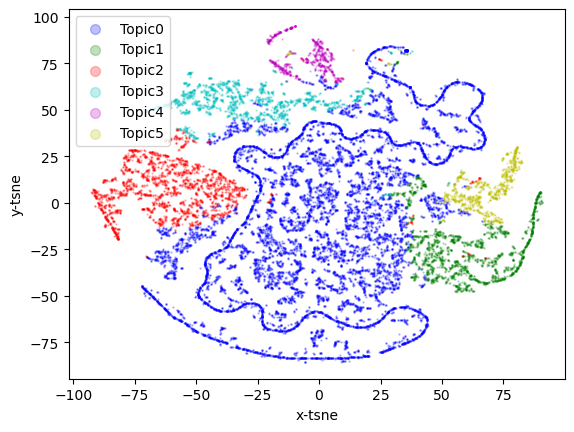

In [ ]:
plot_tsne(nmf_transform, threshold=0)

In [ ]:
# run function
W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [ ]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Word0,"(0.0071, company)","(0.0249, beloved)","(0.0497, president)","(0.1024, times)","(0.2701, editorto)","(0.1755, school)"
Word1,"(0.0068, million)","(0.023, death)","(0.0288, trump)","(0.0945, article)","(0.2299, letter)","(0.0761, student)"
Word2,"(0.0054, first)","(0.0211, family)","(0.0275, republican)","(0.0469, appear)","(0.0558, letters)","(0.0382, college)"
Word3,"(0.0052, years)","(0.0192, notice)","(0.0217, state)","(0.025, review)","(0.0445, editor)","(0.029, university)"
Word4,"(0.0049, american)","(0.0167, husband)","(0.0171, house)","(0.0184, reader)","(0.0395, editorthe)","(0.0224, education)"
Word5,"(0.0049, world)","(0.0163, mother)","(0.017, election)","(0.0154, photo)","(0.0313, editora)","(0.0221, teacher)"
Word6,"(0.0045, state)","(0.0159, father)","(0.0169, obama)","(0.0117, editor)","(0.0309, article)","(0.0157, child)"
Word7,"(0.0041, percent)","(0.0151, friend)","(0.0145, party)","(0.009, misstate)","(0.0236, articleto)","(0.0156, graduate)"
Word8,"(0.0041, people)","(0.0143, services)","(0.0129, senator)","(0.0088, sport)","(0.0122, editorial)","(0.0135, public)"
Word9,"(0.0038, billion)","(0.0129, memorial)","(0.0127, campaign)","(0.0085, title)","(0.0116, respond)","(0.0128, district)"


In [ ]:
H_df.head(1)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Doc0,"(0.0608, Internal Inquiry at Fannie Mae Finds That Executives Man...","(0.1011, LEIFER-Joel. Beloved husband of Doris, devoted father of ...","(0.0843, Aired Wednesday night on NBC: Yesterday, President Bush m...","(0.1501, This word has appeared in 27 New York Times articles in t...","(0.1983, To the Editor:.To the Editor:Advocating Fetal Autopsies (...","(0.1407, Many parents are in an uproar as officials consider plans..."


<h1>Discussion</h1>



In [17]:
# BEST LDA Mdoel
lda = LatentDirichletAllocation(
    n_components=6,
    learning_method='online',
    random_state=0
)

lda.fit(clean_vec1)

LatentDirichletAllocation(learning_method='online', n_components=6,
                          random_state=0)

In [21]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
print(lda_transform.shape)

(24294, 6)


In [22]:
# run function
W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=data['document'],
    ndocs=10, 
    nwords=number_words
)

In [23]:
W_df.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Word0,"(0.0204, company)","(0.0062, review)","(0.0249, article)","(0.0081, season)","(0.0105, state)","(0.0093, school)"
Word1,"(0.0165, million)","(0.0062, photo)","(0.0207, editorto)","(0.0075, first)","(0.01, president)","(0.008, death)"
Word2,"(0.0147, percent)","(0.0061, music)","(0.0165, energy)","(0.0062, world)","(0.0061, unite)","(0.0075, family)"
Word3,"(0.013, billion)","(0.0046, reader)","(0.0152, prime)","(0.0059, player)","(0.0061, government)","(0.0074, police)"
Word4,"(0.0115, market)","(0.0044, museum)","(0.0145, briefing)","(0.0058, fashion)","(0.006, republican)","(0.0065, child)"
Word5,"(0.0096, executive)","(0.0043, video)","(0.0141, letter)","(0.0054, giant)","(0.006, official)","(0.0065, mother)"
Word6,"(0.009, price)","(0.0042, times)","(0.0132, coronavirus)","(0.005, league)","(0.0056, trump)","(0.0059, notice)"
Word7,"(0.0087, business)","(0.0039, story)","(0.0127, editor)","(0.0048, sport)","(0.0054, court)","(0.0056, university)"
Word8,"(0.0084, financial)","(0.0038, night)","(0.012, israel)","(0.0045, coach)","(0.0051, american)","(0.0055, beloved)"
Word9,"(0.0077, chief)","(0.0038, years)","(0.0116, french)","(0.0044, night)","(0.0048, election)","(0.0055, father)"


In [25]:
H_df.head(5)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Doc0,"(0.8455, Evercore Partners reported its first ...","(0.8605, An animated ad on a wall at Eighth Av...","(0.7404, To the Editor:.To the Editor: Bottled...","(0.8408, A selective listing by Times critics ...","(0.8582, Disclosure of the proposal set off po...","(0.8838, MAGIDSON-Karen Zissu. In Westport, CT..."
Doc1,"(0.845, Stock of Concord Communications drops ...","(0.854, In the DOC NYC nonfiction film festiva...","(0.726, MIDDLE EAST.MIDDLE EASTWorld Briefings...","(0.8394, Jacoby Ellsbury stole 70 bases this s...","(0.8565, Editorial says Mayor Rudolph W Giulia...","(0.8806, SCHWARTZ--Gabriel B. Age 78, after a ..."
Doc2,"(0.8323, Global Crossing, operator of transoce...","(0.8459, Gilfema ''Gilfema'' (Obliq Sound) ...","(0.7102, MIDDLE EAST.MIDDLE EASTWorld Briefing...","(0.8388, A selective listing by Times critics ...","(0.8539, President Obama, in his first visit t...","(0.8766, KRANZ-Bob. We are heartbroken over th..."
Doc3,"(0.8313, Santander Central Hispano, Spain’s bi...","(0.8419, To freshen Shakespeare’s popular come...","(0.6988, How to pet-proof your home, facing fo...","(0.8294, The Los Angeles Angels, with Shohei O...","(0.8518, Ecuador's Pres Lucio Gutierrez surviv...","(0.8759, KARCHER--Barbara Jane. Of East Northp..."
Doc4,"(0.831, Reuters Group posts its first loss as ...","(0.8391, Benefit Bazaar Damrosch Park, Linco...","(0.6946, To the Editor:.To the Editor:New York...","(0.8278, Live analysis of the Giants game agai...","(0.85, President Obama confirmed Monday mornin...","(0.8703, SILVERMAN-Samuel J. The partners, cou..."


In [20]:
# iteractive plot
# pca biplot and histogram
lda_plot = pyLDAvis.sklearn.prepare(lda, clean_vec1, vectorizer1, R=10, n_jobs=1)
pyLDAvis.display(lda_plot)

c:\Users\suraj\anaconda3\envs\unsup\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\suraj\anaconda3\envs\unsup\lib\site-packages\pyLDAvis\_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


## **Abstract Topics for LDA Model with 6 Topics**

Our LDA model with six topics demonstrates strong performance by clearly distinguishing themes across the dataset. Below is a breakdown of the topics based on the top terms and inferred themes:

| **Topic #** | **Top Terms**                                                                                                   | **Inferred Theme**                                                                                          |
|-------------|-----------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **Topic 0** | company, million, percent, billion, market, executive, price, business, financial, chief                        | **Business and Economics**: Focuses on financial matters, corporate affairs, markets, and economic updates. |
| **Topic 1** | review, photo, music, reader, museum, video, times, story, night, years                                        | **Arts, Media, and Culture**: Highlights reviews, photography, music, and cultural stories.                 |
| **Topic 2** | article, editorto, energy, prime, briefing, letter, coronavirus, editor, israel, french                        | **Current Events and Global Affairs**: Covers news briefs, editorials, and global topics like COVID-19 and international relations. |
| **Topic 3** | season, first, world, player, fashion, giant, league, sport, coach, night                                      | **Sports and Lifestyle**: Focuses on sports, fashion, and lifestyle trends.                                 |
| **Topic 4** | state, president, unite, government, republican, official, trump, court, american, election                   | **Politics and Governance**: Discusses political figures, elections, and government affairs.                |
| **Topic 5** | school, death, family, police, child, mother, notice, university, beloved, father                              | **Education and Social Issues**: Explores education, family dynamics, and social challenges.                |

---

## **Justification for Model Selection**

The LDA model with 6 topics has the **best performance** for the following reasons:

#### 1. **Clear Topic Separation**
- Each topic captures a distinct theme with minimal overlap.
- For example, Topic 0 (Business and Economics) is focused on financial terms, while Topic 5 (Education and Social Issues) captures societal and educational themes.

#### 2. **Interpretable Terms**
- The top terms within each topic are highly interpretable and aligned with the expected themes of articles from the dataset.
- Example: Topic 4 includes terms like "state," "president," and "government," making it clearly relevant to politics.

#### 3. **Alignment with Use Cases**
- The topics directly support the use cases such as:
  - **Content Categorization**: Automatically tagging articles based on topics (e.g., business, politics, sports).
  - **Personalized Recommendations**: Recommending articles tailored to reader interests (e.g., cultural reviews or sports updates).
  - **Trend Analysis**: Identifying key themes driving public discourse (e.g., COVID-19 in Topic 2).

#### 4. **Visualization Insights**
- The pyLDAvis visualization confirms well-separated clusters with strong term relevance, indicating effective topic modeling.

---

### **Conclusion**

The LDA model with 6 topics has clearly distinguished the themes, making it the best choice for content analysis and recommendation systems. It effectively aligns with the project's goals and provides actionable insights for stakeholders, enabling efficient categorization, segmentation, and personalization.
